In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), '../mermaid'))
import mermaid.module_parameters as pars
import mermaid.model_factory as py_mf
import mermaid.utils as py_utils
import mermaid.similarity_measure_factory as smf
from mermaid.data_wrapper import AdaptVal
import mermaid.image_sampling as py_is
import mermaid.example_generation as eg
ds = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("./files/",
        transform=torchvision.transforms.ToTensor()
    ),
    batch_size=500
)
import numpy as np
images = []
for _, batch in enumerate(ds):
    label = np.array(batch[1])
    batch_nines = label==9
    images.append(np.array(batch[0])[batch_nines])
images = np.concatenate(images)

Will read from /media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/mermaid/../mermaid_settings/compute_settings.json
Will read from /media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/mermaid/../mermaid_settings/compute_settings_comments.json
Will read from /media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/mermaid/../mermaid_settings/baseconf_settings.json
Will read from /media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/mermaid/../mermaid_settings/baseconf_settings_comments.json
Will read from /media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/mermaid/../mermaid_settings/algconf_settings.json
Will read from /media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/mermaid/../mermaid_settings/algconf_settings_comments.json
Will read from /media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/mermaid/../mermaid_settings/democonf_settings.json
Will read from /media/data/anaconda3/envs/mermaid/lib/python3.7/site-packa

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)


def create_model(network_config):
    model = MermaidNet(network_config)
    model.cuda()
    model.apply(weights_init)
    return model




In [8]:
class MermaidNet(nn.Module):
    def __init__(self):
        super(MermaidNet, self).__init__()       
        parameters = pars.ParameterDict()
        self.sz = np.array([1, 1, 28, 28])
        self.spacing = 1./(self.sz[2::]-1) 
        mf = py_mf.ModelFactory(self.sz, self.spacing, self.sz, self.spacing)
        net, loss = mf.create_registration_model(
            'lddmm_shooting_map', parameters["model"])
        loss.add_similarity_measure("ssd", smf.SSDSimilarity)

        _id = py_utils.identity_map_multiN(self.sz, self.spacing)
        self.identityMap = torch.from_numpy(_id).cuda()
        self.mermaid_unit = net.cuda()
        self.mermaid_loss = loss

    def forward(self, moving_image, fixed_image):
        
        #modify self.mermaid_unit.m here
        
        #this call modifies self.phi
        self.warped_moving_image = self.__mermaid_shoot__(moving_image)
        
        all_loss, sim_loss, reg_loss = self.mermaid_loss(
            self.identityMap, 
            self.phi,
            moving_image,
            fixed_image,
            None,
            variables_from_forward_model=self.mermaid_unit.get_variables_to_transfer_to_loss_function(),
            variables_from_optimizer=None
        )
        self.loss_dict = {
            'all_loss': all_loss / self.sz[1],
            'sim_loss': sim_loss / self.sz[1],
            'reg_loss': reg_loss / self.sz[1]
        }

    def __mermaid_shoot__(self, moving_image):
        self.phi=self.mermaid_unit(self.identityMap, moving_image)
        warped_moving_image = py_utils.compute_warped_image_multiNC(
            moving_image, 
            self.phi,
            self.spacing,
            spline_order=1
        )
        return warped_moving_image



net = MermaidNet()
0

Creating new category: root.model
Creating new category: root.model.registration_model
Creating key = type; category = root.model.registration_model; value = lddmm_shooting_map
Creating new category: root.model.registration_model.env
Using default value = False for key = get_momentum_from_external_network of category = root.model.registration_model.env
Using map-based lddmm_shooting_map model
Using default value = True for key = use_CFL_clamping of category = root.model.registration_model
Using default value = True for key = use_odeint of category = root.model.registration_model.env
Using default value = False for key = use_ode_tuple of category = root.model.registration_model.env
Creating new category: root.model.registration_model.forward_model
Creating new category: root.model.registration_model.forward_model.smoother
Using default value = multiGaussian for key = type of category = root.model.registration_model.forward_model.smoother
Using default value = [0.05, 0.1, 0.15, 0.2, 0.25

0

In [9]:
optimizer = torch.optim.Adam(net.parameters(), lr=.1)

In [10]:
net.train()

MermaidNet(
  (mermaid_unit): LDDMMShootingVectorMomentumMapNet(
    (integrator): ODEWrapBlock()
  )
  (mermaid_loss): LDDMMShootingVectorMomentumMapLoss()
)

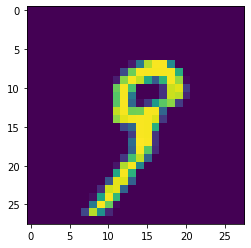

In [11]:
import matplotlib.pyplot as plt
plt.imshow(images[1, 0])

/media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


[0.65522814]
[0.65244293]
[0.6476452]
[0.65165067]
[0.6436938]
[0.63572437]
[0.63621694]
[0.6335288]
[0.6312078]
[0.62309825]
[0.62462926]
[0.6149878]
[0.6132395]
[0.6120178]
[0.6059178]
[0.6062758]
[0.6037084]
[0.6008526]
[0.5993233]
[0.595933]
[0.59354603]
[0.59235954]
[0.5889622]
[0.58875906]
[0.5884477]
[0.5916164]
[0.5929865]
[0.5813067]
[0.612018]
[0.63677686]
[0.57684195]
[0.63810354]
[0.61636156]
[0.604571]
[0.6056956]
[0.5953936]
[0.5911179]
[0.59931576]
[0.5932466]
[0.58101]
[0.5832541]
[0.5864608]
[0.566122]
[0.5828874]
[0.56335783]
[0.5679273]
[0.5627113]
[0.5608219]
[0.5614717]
[0.5561955]
[0.55375546]
[0.55524784]
[0.5515274]
[0.55334246]
[0.54573846]
[0.54621255]
[0.54542506]
[0.54209036]
[0.5419631]
[0.5435565]
[0.5382463]
[0.5390882]
[0.53923804]
[0.5360059]
[0.5347039]
[0.53625315]
[0.5316403]
[0.53132653]
[0.53021383]
[0.529662]
[0.52762705]
[0.52786523]
[0.52624494]
[0.5265635]
[0.5244988]
[0.524081]
[0.523084]
[0.52258444]
[0.52213967]
[0.52130353]
[0.5214502]
[0.5

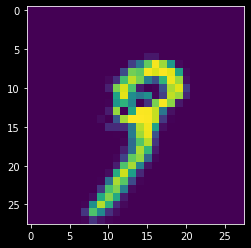

In [22]:
for _ in range(100):
    moving_image = torch.tensor(images[:1]).cuda()
    fixed_image = torch.tensor(images[1:2]).cuda()
    optimizer.zero_grad()
    net(moving_image, fixed_image)
    loss = net.loss_dict["all_loss"]
    loss.backward()
    optimizer.step()
    print(loss.cpu().detach().numpy())
plt.imshow(np.array(net.warped_moving_image[0, 0].detach().cpu()))

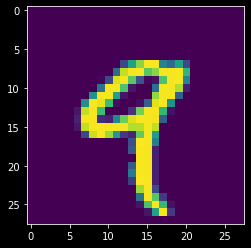

In [23]:
plt.imshow(images[0, 0])

In [24]:
phi = np.array((net.phi).cpu().detach())[0]
iden = np.array(net.identityMap.cpu())[0]

In [25]:
iden.shape

(2, 28, 28)

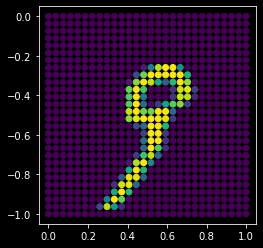

In [49]:
plt.style.use("dark_background")
plt.axes().set_aspect("equal")
l = 1
a = l * iden + (1 - l) * phi
plt.scatter(a[1].flatten(), -a[0].flatten(), 
            c=fixed_image.cpu()[0, 0].flatten())

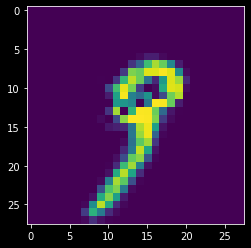

In [21]:
plt.imshow(np.array(net.warped_moving_image[0, 0].detach().cpu()))